In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Input, Embedding,TimeDistributed, LSTM, Dropout, Bidirectional, Dense 
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import plot_model, to_categorical

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
df = pd.read_csv('ner_dataset.csv', encoding='latin1')
df = df.fillna(method = 'ffill')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O


In [ ]:
print("Number of sentences: ", len(df.groupby(['Sentence #'])))

words = list(set(df["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(df["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['B-geo', 'B-tim', 'I-art', 'O', 'B-eve', 'I-gpe', 'B-gpe', 'I-per', 'I-eve', 'B-art', 'B-per', 'I-tim', 'B-org', 'I-org', 'B-nat', 'I-nat', 'I-geo']
Number of Labels:  17


In [ ]:
labels = df.Tag.values
classes = np.unique(labels)
classes = classes.tolist()
labels1 = classes.copy()
labels1.pop()
labels1

['B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim']

In [ ]:
labels2= [x[-3:] for x in labels1]
labels2=np.unique(labels2)
labels2

array(['art', 'eve', 'geo', 'gpe', 'nat', 'org', 'per', 'tim'],
      dtype='<U3')

In [ ]:
class SentenceTagger(object):
    
    def __init__(self, dataset, word_col, tag_col, sent_id_col):
        self.n_sent = 1
        self.dataset = dataset
        self.empty = False
        agg_func = lambda s: [
            (w, t) for w,t in zip(s[word_col].values.tolist(), s[tag_col].values.tolist())
        ]
        self.grouped = self.dataset.groupby(sent_id_col).apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None


# Get all the sentences
tagged = SentenceTagger(dataset=df, word_col='Word', tag_col='Tag', sent_id_col='Sentence #')
sentences = tagged.sentences
print(sentences[0])

[('Thousands', 'O'), ('of', 'O'), ('demonstrators', 'O'), ('have', 'O'), ('marched', 'O'), ('through', 'O'), ('London', 'B-geo'), ('to', 'O'), ('protest', 'O'), ('the', 'O'), ('war', 'O'), ('in', 'O'), ('Iraq', 'B-geo'), ('and', 'O'), ('demand', 'O'), ('the', 'O'), ('withdrawal', 'O'), ('of', 'O'), ('British', 'B-gpe'), ('troops', 'O'), ('from', 'O'), ('that', 'O'), ('country', 'O'), ('.', 'O')]


In [ ]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

from keras.preprocessing.sequence import pad_sequences

maxlen = max([len(s) for s in sentences])
# Convert each sentence from list of Token to list of word_index
X = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same length
X = pad_sequences(maxlen=maxlen, sequences=X, padding="post", value=word2idx["PAD"])

# Convert Tag to tag_index
y = [[tag2idx[w[1]] for w in s] for s in sentences]
# Padding each sentence to have the same length
y = pad_sequences(maxlen=maxlen, sequences=y, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encoding
y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

X_tr = X[:40000]
X_te = X[40000:]
y_tr = y[:40000]
y_te = y[40000:]
X_tr.shape, X_te.shape, np.array(y_tr).shape, np.array(y_te).shape

((40000, 104), (7959, 104), (40000, 104, 18), (7959, 104, 18))

In [ ]:
print('Raw Sample      :', ' '.join([w[0] for w in sentences[0]]))
print('Processed Sample:', X[0])

Raw Sample      : Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Processed Sample: [  247  8320   888  1001 14326 31774 26648 34521 16507 16632  7994 18316
 14810 33373 34884 16632 12803  8320 20812 34171 23891 27706 29344 10889
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [ ]:
print('Raw Label      :', ' '.join([w[1] for w in sentences[0]]))
print('Processed Label:', y[0])

Raw Label      : O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
Processed Label: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
# Install extra-dependencies
! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

     |████████████████████████████████| 747kB 5.6MB/s 


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 104, 64)           2251520   
_________________________________________________________________
dropout (Dropout)            (None, 104, 64)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 104, 128)          66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 104, 128)          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 104, 18)           2322      
Total params: 2,319,890
Trainable params: 2,319,890
Non-trainable params: 0
_________________________________________________________________


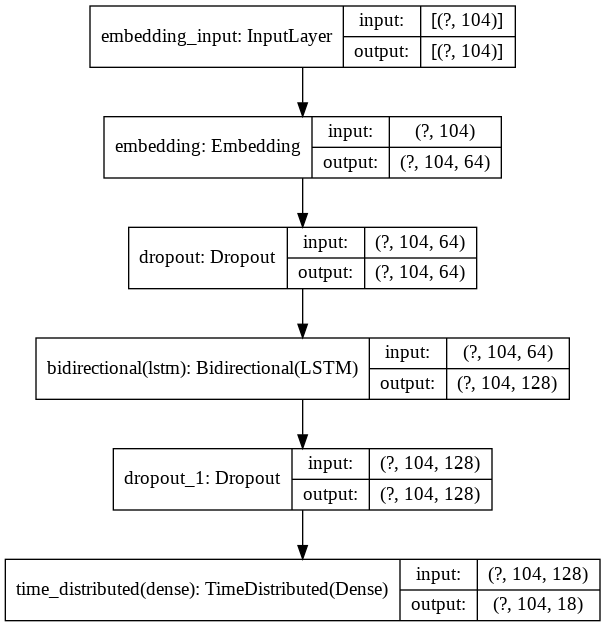

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7)
filepath = "model.h4"
ckpt = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
rlp = ReduceLROnPlateau(monitor='loss', patience=3, verbose=1)

model_4 = Sequential()
model_4.add(Embedding(input_dim=n_words+2, output_dim=64, input_length=maxlen))
model_4.add(Dropout(0.5))
model_4.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.2, recurrent_dropout= 0.2)))
model_4.add(Dropout(0.5))
model_4.add(TimeDistributed(Dense(n_tags+1, activation='softmax')))

model_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_4.summary()
plot_model(model_4, show_shapes=True)

In [ ]:
history3 = model_4.fit(X_tr, np.array(y_tr), batch_size=32 , validation_split=0.1,callbacks=[es, ckpt, rlp], epochs=5)

Epoch 1/5
1125/1125 [==============================] - ETA: 0s - loss: 0.1620 - accuracy: 0.9639
Epoch 00001: loss improved from inf to 0.16203, saving model to model.h4
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model.h4/assets
1125/1125 [==============================] - 338s 301ms/step - loss: 0.1620 - accuracy: 0.9639 - val_loss: 0.0565 - val_accuracy: 0.9848
Epoch 2/5
1125/1125 [==============================] - ETA: 0s - loss: 0.0446 - accuracy: 0.9878
Epoch 00002: loss improved from 0.16203 to 0.04457, saving model to model.h4
INFO:tensorflow:Assets written to: model.h4/assets
1125/1125 [==============================] - 331s 295ms/step - loss: 0.0446 - accuracy: 0.9878 - val_loss: 0.0306 - val_accuracy: 0.9912
Epoch 3/5
1125/1125 [=========================

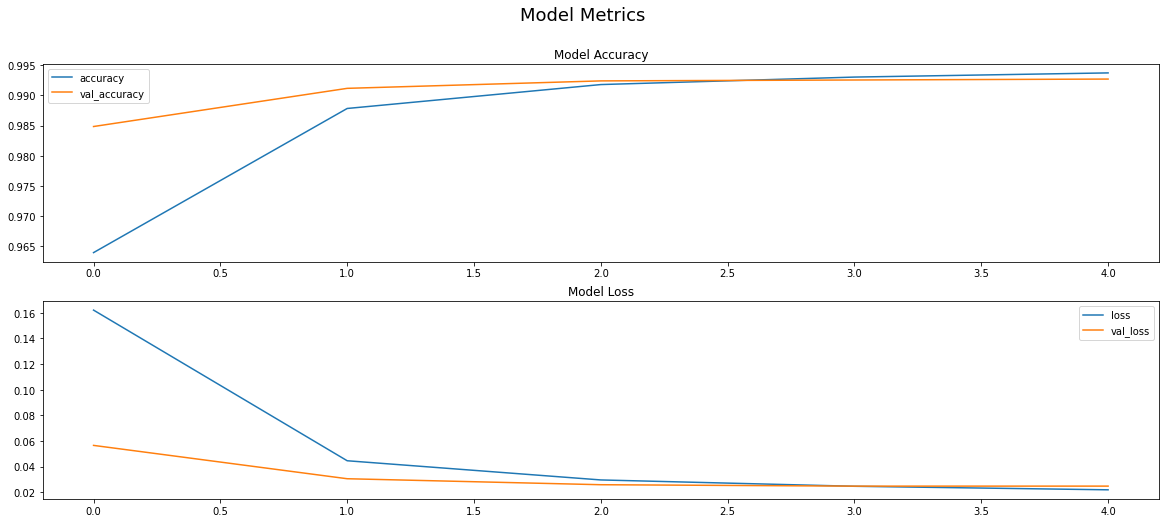

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(20, 8))
df3 = pd.DataFrame(history3.history)
df3[['accuracy', 'val_accuracy']].plot(ax=ax[0])
df3[['loss', 'val_loss']].plot(ax=ax[1])
ax[0].set_title('Model Accuracy', fontsize=12)
ax[1].set_title('Model Loss', fontsize=12)
fig.suptitle('Model Metrics', fontsize=18);

In [ ]:
df3

,loss,accuracy,val_loss,val_accuracy,lr
0,0.162034,0.963932,0.056549,0.984846,0.001
1,0.044573,0.987838,0.030551,0.991178,0.001
2,0.029606,0.991805,0.025883,0.992413,0.001
3,0.024665,0.993047,0.024776,0.992562,0.001
4,0.021908,0.993739,0.024791,0.992716,0.001


In [ ]:
from sklearn_crfsuite.metrics import flat_classification_report

In [ ]:
def new_ents(tag):
  if tag == 'O':
    return 'O'
  elif tag == 'PAD':
    return 'O'
  else:
    return tag[-3:]

In [ ]:
pred_cat3 = model_4.predict(X_te)
pred3 = np.argmax(pred_cat3, axis=-1)
y_te_true3 = np.argmax(y_te, -1)

# Convert the index to tag
pred_tag3 = [[idx2tag[i] for i in row] for row in pred3]
true_tag3 = [[idx2tag[i] for i in row] for row in y_te_true3] 

pred_tag3 = [[new_ents(x) for x in row] for row in pred_tag3]
true_tag3 = [[new_ents(x) for x in row] for row in true_tag3]

print(flat_classification_report(y_pred=pred_tag3, y_true=true_tag3,labels=labels2))

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         art       0.00      0.00      0.00       109
         eve       0.00      0.00      0.00       100
         geo       0.86      0.86      0.86      7536
         gpe       0.95      0.91      0.93      2828
         nat       0.00      0.00      0.00        47
         org       0.80      0.71      0.76      5964
         per       0.90      0.81      0.85      5581
         tim       0.93      0.88      0.90      4369

   micro avg       0.88      0.82      0.85     26534
   macro avg       0.56      0.52      0.54     26534
weighted avg       0.87      0.82      0.84     26534



In [ ]:
for i in range(5):
  p = model_4.predict(np.array([X_te[i]]))
  p = np.argmax(p, axis=-1)
  true = np.argmax(y_te[i], -1)

  print("Sample number {} of {} (Test Set)".format(i, X_te.shape[0]))
# Visualization
  print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
  print(30 * "=")
  for w, t, pred in zip(X_te[i], true, p[0]):
      if w != 0:
          print("{:15}: {:5} {}".format(words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 0 of 7959 (Test Set)
Word           ||True ||Pred
Pakistani      : B-gpe B-gpe
officials      : O     O
say            : O     O
unidentified   : O     O
gunmen         : O     O
have           : O     O
killed         : O     O
three          : O     O
people         : O     O
,              : O     O
including      : O     O
a              : O     O
former         : O     O
government     : O     O
minister       : O     O
,              : O     O
in             : O     O
a              : O     O
semi-autonomous: O     O
tribal         : O     O
region         : O     O
bordering      : O     O
Afghanistan    : B-geo B-geo
.              : O     O
Sample number 1 of 7959 (Test Set)
Word           ||True ||Pred
China          : B-geo B-geo
's             : O     O
official       : O     O
Xinhua         : B-org B-org
news           : O     O
agency         : O     O
says           : O     O
archaeologists : O     O
have           : O     O
discovered     : O     O
the   

In [ ]:
1+1

2